# LDA and MNIST

In this notebook we will do use multiclass LDA to classify MNIST. If you are using your own installation of Jupyter you will need the mnist package which can be installed through anaconda using

conda install -c conda-forge mnist

I must point out that no efforts have been made to optimise this code for either efficiency or elegance, and some of you will no doubt be able to find ways in which it could be improved.

**CAUTION** these notebooks are great, but you must be careful when running the cells out of order, especially if you are using mutable variables

In [1]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
from numpy.linalg import inv, det


First, some manipulations. We need to linearise the training data so that we can treat each image as a vector.

In [2]:
# Get the training and test data
train_set = mnist.train_images()
train_labels = mnist.train_labels()
test_set = mnist.test_images()
test_labels = mnist.test_labels()
print(test_set.shape)
print(train_set.shape)

# Reshape the arrays
test_set = np.squeeze(np.array([np.reshape(i,(1,-1)) for i in test_set]))
train_set = np.squeeze(np.array([np.reshape(i,(1,-1)) for i in train_set]))
print(test_set.shape)
print(train_set.shape)

(10000, 28, 28)
(60000, 28, 28)
(10000, 784)
(60000, 784)


We define the multivariate gaussian, which is at the core of the model that we will learn.
$$  P(\mathbf{x}|\Pi_n)=f_n(\mathbf{x}) = \frac{1}{(2\pi)^{r/2}|\mathbf{\Sigma}|^{1/2}}\exp{(-\frac{1}{2}(\mathbf{x}-\langle\mathbf{x}_n\rangle)^\mathrm{T}}\mathbf{\Sigma}^{-1}(\mathbf{x}-\langle\mathbf{x}_n\rangle))
$$
Note that for LDA, the normalising constant $\frac{1}{(2\pi)^{r/2}|\mathbf{\Sigma}|^{1/2}}$ is the same for all classes and we can ignore it.

In [4]:
def multinormal(x, mu, invSigma):
  # We will pass in the inverse of the covariance matrix so we only have to invert it once
  # we have to explictly convert this from a singleton vector to a scalar
  return np.asscalar(np.exp(-0.5*(x-mu)*invSigma*(x-mu).transpose()))
  

## Training

Let's now write a function to learn the distribution parameters - a training function. We will need the definition of the covariance
$$\Sigma_{ij} = \frac{1}{N-1}\sum_{n=1}^N \left(x_i^{(n)}-\bar x_i\right)\left(x_j^{(n)}-\bar x_j\right)$$

or 

$$\Sigma = \frac{1}{N-1}\left(X-\bar X\right)^T\left(X-\bar X\right) = \tilde X^T\tilde X$$

where each column of X is a variable and each row is a sample

In [5]:
def lda_train(data,labels):
  # Compute the class priors, store in a dictionary with the class as the key
  class_priors = dict()
  for label in set(labels):
    class_priors[label] = np.sum([labels==label])/data.shape[0]
    
  # Calculate all the class means
  class_means = dict()
  for label in set(labels):
    # select the elements from the current class and compute their mean
    class_data = data[labels==label]
    class_means[label] = np.mean(class_data,axis=0)
    
  # Now zero-mean all class and compute the covariance
  # We have to do this so that we only include intra-class variance and not inter-class variance
  zeromeandata = []
  for index,item in enumerate(data):
    zeromeandata.append(item - class_means[labels[index]])
  # Once the data is zero-mean, we can compute the covariance easily as X^T X
  X = np.matrix(np.squeeze(np.array(zeromeandata)))
  Sigma = X.transpose()*X/(train_labels.size - 1)
  
  return class_means, Sigma, class_priors

## Evaluating
For each item in the test set, we compute $P(\Pi_i|x)\pi_i$ for each class $i$ and choose the maximum.

In [17]:
def lda_predict(data, class_means, invSigma, class_priors):
  # For each sample evaluate the PDFs for each class
  predictions = []
  for index,i in enumerate(data):
    class_probs = [(j,class_priors[j]*multinormal(np.matrix(i),class_means[j],invSigma)) for j in class_means]
    predictions.append(max(class_probs, key=lambda item: item[1])[0])
  return(predictions)
    

## Preprocessing of the data

One problem with the MNIST data is that there are, as we have previously seen, many non-varying pixels around the edge of the images. We need to remove these because they mean that the covariance matrix is not full-rank: the corresponding rows and columns are all zero and hence the rows/columns of the covariance matrix are not linearly independent and the matrix cannot be inverted.

We deal with this by removing these variable from the problem. They can have no influence on the classification process as they are identical for all classes.



In [18]:
# Get the sum of each variable into a single vector
S = np.sum(train_set,axis=0).squeeze()

# Define an index of the non-varying and varying pixels
nonvary = S==0
vary = np.array(S!=0).squeeze()

# Choose only the varying pixels in the data
train_set = train_set[:,vary]
test_set = test_set[:,vary]

## Training the model

We call the training function on the training data

In [19]:
class_means,Sigma,class_priors = lda_train(train_set, train_labels)

## Testing

Now run the predictions on the test data. Note that we pass in the inverse of Sigma

In [20]:
predictions = lda_predict(test_set, class_means, inv(Sigma),class_priors)

## Evaluating

We compute some evaluation metrics on the outcome (ie the confusion matrix)

In [21]:
def evaluate(predicted_labels, true_labels):
    # Create an empty confusion matrix
    confusion_matrix = np.zeros([10,10])
    
    # For each item in the test set, add it's prediction into the confusion matrix
    for i, l in enumerate(true_labels):
        confusion_matrix[l, predicted_labels[i]] += 1
    
    # Normalise each row
    for i, row in enumerate(confusion_matrix):
        confusion_matrix[i] /= sum(confusion_matrix[i])
        
    # Print the matrix (formatted for copying into a latex document)
    for i,c in enumerate(confusion_matrix):
        print(str(i) + ' & ' + ' & '.join(['{:3.2f}'.format(i) for i in c]) + '\\\\ \hline')
    
    # Plot the matrix
    plt.imshow(confusion_matrix,cmap='gray')
    plt.tight_layout()
    plt.grid('off')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    
    # Compute and print the overall accuracy
    print(sum(confusion_matrix.diagonal())/sum(sum(confusion_matrix)))

0 & 0.96 & 0.00 & 0.00 & 0.00 & 0.00 & 0.01 & 0.01 & 0.00 & 0.01 & 0.00\\ \hline
1 & 0.00 & 0.96 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.02 & 0.00\\ \hline
2 & 0.09 & 0.03 & 0.73 & 0.03 & 0.02 & 0.00 & 0.03 & 0.01 & 0.05 & 0.00\\ \hline
3 & 0.07 & 0.00 & 0.02 & 0.82 & 0.00 & 0.02 & 0.00 & 0.01 & 0.03 & 0.01\\ \hline
4 & 0.03 & 0.01 & 0.01 & 0.00 & 0.88 & 0.00 & 0.01 & 0.00 & 0.01 & 0.05\\ \hline
5 & 0.05 & 0.01 & 0.00 & 0.04 & 0.01 & 0.79 & 0.02 & 0.01 & 0.04 & 0.02\\ \hline
6 & 0.12 & 0.01 & 0.01 & 0.00 & 0.02 & 0.03 & 0.79 & 0.00 & 0.02 & 0.00\\ \hline
7 & 0.09 & 0.03 & 0.01 & 0.01 & 0.02 & 0.00 & 0.00 & 0.77 & 0.00 & 0.07\\ \hline
8 & 0.04 & 0.03 & 0.01 & 0.03 & 0.02 & 0.04 & 0.01 & 0.00 & 0.80 & 0.03\\ \hline
9 & 0.04 & 0.01 & 0.00 & 0.01 & 0.06 & 0.00 & 0.00 & 0.04 & 0.01 & 0.83\\ \hline
0.8334997601216017


C:\Users\ibs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


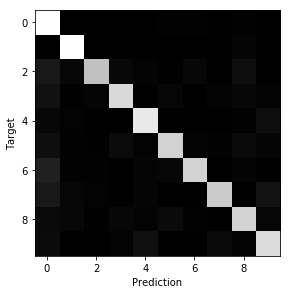

In [22]:
evaluate(predictions, test_labels)

## Generating new samples

Because we have estimated the underlying distribution of each class, we can resample from  the class-conditional distributions to generate new examples



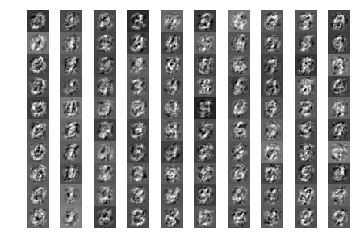

In [23]:
# Lay out the figure
fig, ax = plt.subplots(10,10)
plt.subplots_adjust(wspace=0, hspace=0)

# For each class
for i in class_means:
  # Generate ten samples
  samples = np.random.multivariate_normal(class_means[i], Sigma, 10)
  for j,im in enumerate(samples):
    # Remember that we are only working with the varying pixels so we have to poke them into the correct places in the image
    x = np.zeros(784)
    x[vary] = im
    ax[j,i].imshow(np.reshape(x,(28,28)), cmap='gray')
    ax[j,i].set_axis_off()

## A few more examples
Let's generate a few more

In [1]:
c = 8
sample = np.random.multivariate_normal(class_means[c], Sigma, 1)
x = np.zeros(784)
x[vary] = np.squeeze(sample)
plt.imshow(np.reshape(x,(28,28)), cmap='gray')
plt.axis('off')


NameError: name 'np' is not defined